In [57]:
import torch
import torchvision
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from scipy.spatial.distance import cdist
import json
import os

In [ ]:
class ResNetFeatureExtractor(torch.nn.Module):
    # ResNet18 is chosen due to its balance between computational efficiency and feature extraction power.
    # It is not as computationally heavy as deeper models like ResNet50 or ResNet101 but still captures
    # sufficient hierarchical features, making it a good fit for image similarity tasks.
    # The architecture is based on residual learning, allowing gradients to bypass certain layers through skip connections,
    # effectively mitigating vanishing gradient problems that are more pronounced in deeper networks.
    # Additionally, ResNet18 provides a 512-dimensional feature vector, which is compact yet informative for similarity comparison.
    def __init__(self, fine_tune_layers=None):
        super(ResNetFeatureExtractor, self).__init__()
        # Load the pre-trained ResNet18 model
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Freeze all layers initially => to prevent unnecessary computtaions and reduce memory overhead during inference
        for param in resnet.parameters():
            param.requires_grad = False

        # Unfreeze specific layers
        #Specific layers can be unfrozen to adapt to domain-specific features.
        # This is particularly useful if the dataset contains significantly different visual patterns
        # compared to the original ImageNet dataset.
        if fine_tune_layers:
            for layer_name in fine_tune_layers:
                #Selective fine-tuning allows specific layers to be trainable, 
                #potentially enhancing the feature extraction capability for domain-specific data. 
                #However, for retrieval tasks, it is often more effective to use pre-trained weights 
                #directly unless the dataset distribution differs significantly from the original training set.
                layer = getattr(resnet, layer_name, None)
                if layer:
                    for param in layer.parameters():
                        param.requires_grad = True

        # Extract all layers except the final classification layer
        #This vector serves as the basis for similarity comparison using Euclidean or cosine distance.
        self.feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])

    def forward(self, x):
        # Pass the input through the feature extractor
        features = self.feature_extractor(x)
        # Flatten the output to a 2D tensor
        return features.view(features.size(0), -1)

In [ ]:
def fine_tune_model(model, train_loader, device, epochs=5, lr=0.001):
    # The fine-tuning function enables the model to adapt to domain-specific data by updating the weights
    # of the specified layers. This is particularly beneficial when the pre-trained model was trained
    # on a dataset with a different distribution or set of classes.
    # Here, we use CrossEntropyLoss as the loss function, which is suitable for multi-class classification tasks.
    # Adam optimizer is chosen for its adaptive learning rate capabilities, making it more effective
    # than standard SGD in converging quickly while maintaining stability.

    model.train() # Set the model to training mode to enable gradient tracking
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    #Adam => optimizer => special calculator that adjust the model's learning rate = making it learn quickly without overshooting
    
    loss_fn = torch.nn.CrossEntropyLoss()
    # Filtering the parameters to only include those that are set to requires_grad=True ensures that
    # we are only optimizing the layers that are designated for fine-tuning.

    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() # Clear previous gradients to prevent accumulation
            outputs = model(inputs) # Forward pass through the model
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step() # Update the weights
            total_loss += loss.item()
        # Printing epoch-wise loss provides insight into the model's convergence
        # and helps in identifying potential overfitting or underfitting issues.
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

In [ ]:
def get_data_loader(data_path, batch_size=16, num_workers=4):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)), #resize images to 224x224 pixels 
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]) #normalization helps model learn better... 
    dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return data_loader, dataset



In [ ]:
def extract_features(model, data_loader, device):
    model.eval() #tell model to just look at the images => eval() => not learning anything new...
    features, file_names = [], [] #collect festuresand filenames
    
    with torch.no_grad():#torch.no_grad => saves it in memoryand seepds up processing
        for inputs, _ in data_loader:
            inputs = inputs.to(device)  # Move inputs to the appropriate device
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())  # Move outputs to CPU for further processing
            file_names.extend([sample[0] for sample in data_loader.dataset.samples])
    features = np.vstack(features)
    return features, file_names

In [ ]:
def generate_submission_json(features, file_names, k=5): #find k closest images...
    distances = cdist(features, features, metric='euclidean')
    submission = []
    num_images = len(file_names)  # Total number of images in the dataset

    for idx, file_name in enumerate(file_names):
        sorted_indices = np.argsort(distances[idx])
        # Ensure k does not exceed the number of available images
        top_k = min(k, num_images - 1)  # Exclude the query image itself
        top_k_indices = sorted_indices[1:top_k + 1]  # Skip the first index (itself)
        top_k_files = [file_names[i] for i in top_k_indices]
        submission.append({
            "filename": file_name,
            "samples": top_k_files
        })

    with open('submission.json', 'w') as f:
        json.dump(submission, f)
    return submission

In [93]:

def compute_top_k_accuracy(true_labels, top_k_labels, k=5):
    correct_count = sum(1 for true_label, top_k in zip(true_labels, top_k_labels) if true_label in top_k)
    return correct_count / len(true_labels)

from sklearn.metrics import average_precision_score

def compute_map(true_labels, top_k_labels, num_classes, k=2):
    aps = []
    true_one_hot = np.zeros((len(true_labels), num_classes))

    for i, label in enumerate(true_labels):
        true_one_hot[i, label] = 1

    for i in range(len(true_labels)):
        # Create a zero vector of length num_classes
        relevant = np.zeros(num_classes)
        # Mark the top-k predicted labels as 1
        for label in top_k_labels[i]:
            relevant[label] = 1

        # Calculate average precision
        ap = average_precision_score(true_one_hot[i], relevant)
        aps.append(ap)

    return np.mean(aps)




In [77]:
# Training and Testing Loop
def train_step(loader, model, optimizer, loss_fn):
    model.train()
    total_loss, total_correct = 0, 0

    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()

    return total_loss / len(loader), total_correct / len(loader.dataset)

def test_step(loader, model, loss_fn):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()

    return total_loss / len(loader), total_correct / len(loader.dataset)

In [81]:
import matplotlib.pyplot as plt
from PIL import Image

def visualize_retrieval(query_image_path, retrieved_image_paths):
    fig, axes = plt.subplots(1, len(retrieved_image_paths) + 1, figsize=(15, 5))
    query_image = Image.open(query_image_path)
    axes[0].imshow(query_image)
    axes[0].set_title("Query Image")
    axes[0].axis("off")

    for i, retrieved_image_path in enumerate(retrieved_image_paths):
        retrieved_image = Image.open(retrieved_image_path)
        axes[i + 1].imshow(retrieved_image)
        axes[i + 1].set_title(f"Retrieved {i + 1}")
        axes[i + 1].axis("off")

    plt.show()

Using device: cpu
Epoch 1/3, Loss: 6.5329
Epoch 2/3, Loss: 5.8307
Epoch 3/3, Loss: 5.4594
Top-2 Accuracy: 0.9167

Visualizing retrieval for a query image...


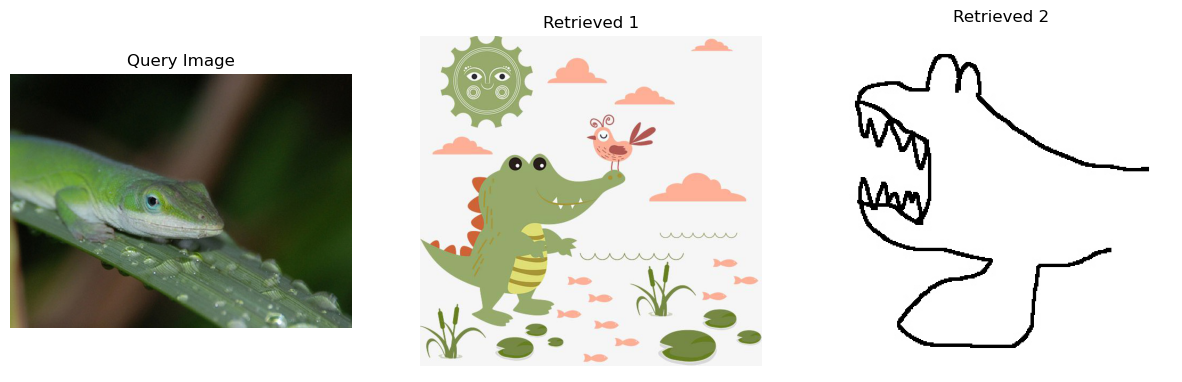


Experimenting with different values of k...


IndexError: index 36 is out of bounds for axis 0 with size 36

In [95]:
if __name__ == "__main__":
    config = {
        "batch_size": 16,
        "epochs": 3,
        "learning_rate": 0.001,
        "k": 2
    }

    data_path = os.path.join(os.getcwd(), 'data', 'training')
    test_path = os.path.join(os.getcwd(), 'data', 'test')

    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize model with fine-tuning for layer3 and layer4
    model = ResNetFeatureExtractor(fine_tune_layers=['layer3', 'layer4']).to(device)

    # Load data
    train_loader, train_dataset = get_data_loader(data_path, config["batch_size"])
    test_loader, _ = get_data_loader(test_path, config["batch_size"])

    # Fine-tune the model
    fine_tune_model(model, train_loader, device, epochs=config["epochs"], lr=config["learning_rate"])

    # Extract features
    train_features, train_file_names = extract_features(model, train_loader, device)
    test_features, test_file_names = extract_features(model, test_loader, device)

    # Generate submission
    submission = generate_submission_json(test_features, test_file_names, k=config["k"])

    # Optionally, evaluate top-k accuracy if ground truth is available
    true_labels = [label for _, label in train_dataset.samples]
    distances = cdist(train_features, train_features, metric='euclidean')
    top_k_labels = []

    for idx in range(len(train_features)):
        sorted_indices = np.argsort(distances[idx])
        top_k_indices = sorted_indices[1:config["k"] + 1]
        top_k_labels.append([train_dataset.samples[i][1] for i in top_k_indices])

    top_k_accuracy = compute_top_k_accuracy(true_labels, top_k_labels, k=config["k"])
    print(f"Top-{config['k']} Accuracy: {top_k_accuracy:.4f}")

     # Visualize retrieval for a query image
    print("\nVisualizing retrieval for a query image...")
    query_image_path = train_file_names[0]  # Example query image
    retrieved_image_paths = submission[0]["samples"]  # Retrieved images for the query
    visualize_retrieval(query_image_path, retrieved_image_paths)

    # Experiment with different values of k
    print("\nExperimenting with different values of k...")
    for k in [1, 3, 5]:
        submission = generate_submission_json(train_features, train_file_names, k=k)
        top_k_accuracy = compute_top_k_accuracy(true_labels, top_k_labels, k=k)
        print(f"Top-{k} Accuracy: {top_k_accuracy:.4f}")